In [2]:
%load_ext autoreload

In [4]:
%autoreload 2
from guitarsounds import Sound, Signal
import guitarsounds as guit

In [5]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Apply peak finding algorithm for harmonic signal fourier transform

In [6]:
# Get a signal to test
wood = Sound('soundfiles/flax_carbon/Wood_D0_2.wav')
wood.condition()

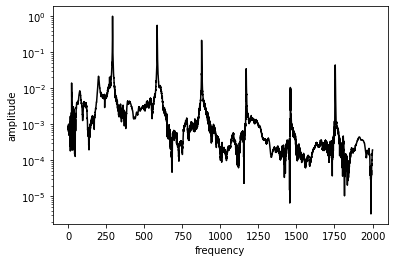

In [7]:
wood.signal.plot(kind='fft', color='k')

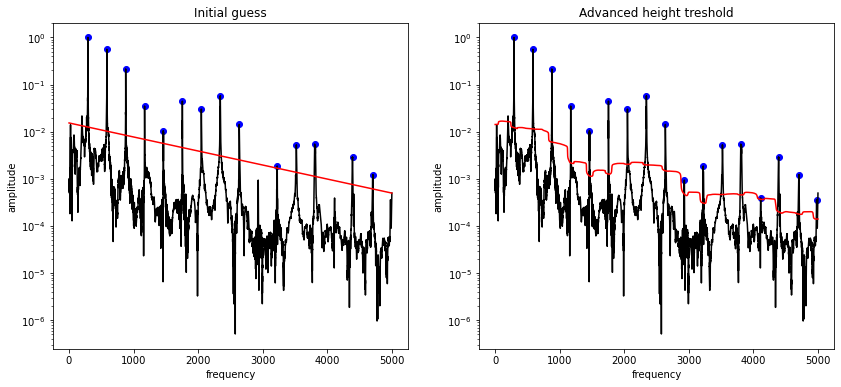

In [8]:
# Get the fft and fft frequencies from the signal
wood.SP.general.fft_range.value = 5000
fft, fft_freq = wood.signal.fft(), wood.signal.fft_frequencies()

# Find the max index 
max_index = np.where(fft_freq >= wood.SP.general.fft_range.value)[0][0]

freq = fft_freq[np.argmax(fft)]
peak_distance = np.argmax(fft)//2

fft_max_start = np.max(fft[:peak_distance])
fft_max_end = np.max(fft[max_index-peak_distance:max_index])


first_exponent = np.log10(fft_max_start)
last_exponent = np.log10(fft_max_end)
exponents = np.linspace(first_exponent, last_exponent, max_index)
intersect = 10 ** exponents[peak_distance]
diff_start = fft_max_start - intersect

first_exponent = np.log10(fft_max_start + diff_start)
exponents = np.linspace(first_exponent, last_exponent, max_index)
min_height = 10 ** exponents

first_peak_indexes, _ = sig.find_peaks(fft[:max_index], height=min_height, distance=peak_distance)

number_of_peaks = len(first_peak_indexes)
average_len = int(max_index/number_of_peaks)*3

if average_len%2 == 0:
    average_len+=1
    
average_fft = sig.savgol_filter(fft[:max_index], average_len, 1, mode='mirror')*2

peak_indexes, _ = sig.find_peaks(fft[:max_index], height=average_fft, distance=peak_distance)


# Plotting
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
wood.signal.plot(kind='fft', color='k')
ax = plt.gca()
#ax.plot([fft_freq[peak_distance], fft_freq[peak_distance]], [0, 1], color='r')
#ax.plot([fft_freq[0], fft_freq[peak_distance]], [fft_max_start, fft_max_start], color='r')
#ax.plot([fft_freq[max_index-peak_distance], fft_freq[max_index-peak_distance]], [0, 1], color='r')
#ax.plot([fft_freq[max_index-peak_distance], fft_freq[max_index]], [fft_max_end, fft_max_end], color='r')
ax.plot(fft_freq[:max_index], min_height, '-r')
ax.scatter(fft_freq[first_peak_indexes], fft[first_peak_indexes], color='b')
ax.set_title('Initial guess')

plt.subplot(1,2,2)
ax = plt.gca()
wood.signal.plot(kind='fft', color='k')
ax.plot(fft_freq[:max_index], average_fft, color='r')
ax.scatter(fft_freq[peak_indexes], fft[peak_indexes], color='b')
ax.set_title('Advanced height treshold')
plt.show()


## Implementation 

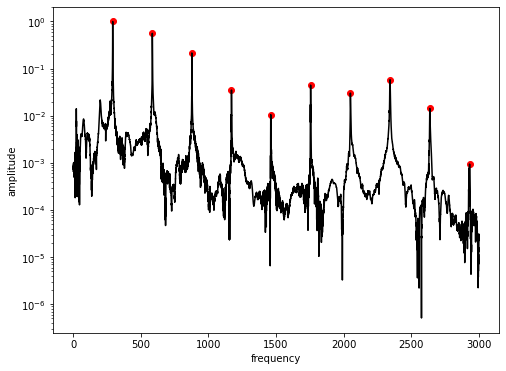

In [9]:
wood.SP.change('fft_range', 3000)
plt.figure(figsize=(8,6))
wood.signal.plot(kind='fft', color='k')
plt.scatter(wood.signal.fft_frequencies()[wood.signal.peaks()], wood.signal.fft()[wood.signal.peaks()], color='r')
plt.show()

## Compare the peaks of two signals

In [10]:
carbon = Sound('soundfiles/flax_carbon/Carbon_D0_2.wav')
carbon.condition()
carbon.SP.change('fft_range', 3000)

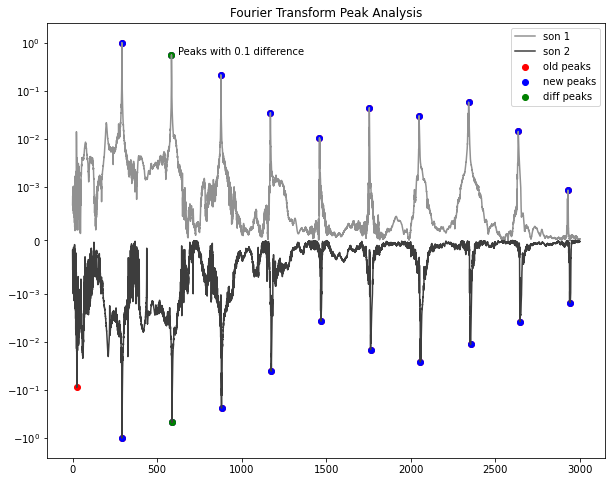

In [60]:
index1 = np.where(wood.signal.fft_frequencies() > wood.SP.general.fft_range.value)[0][0]
index2 = np.where(carbon.signal.fft_frequencies() > wood.SP.general.fft_range.value)[0][0]

# Get the peak data from the sounds
peaks1 = wood.signal.peaks()
peaks2 = carbon.signal.peaks()
freq1 = wood.signal.fft_frequencies()[:index1]
freq2 = carbon.signal.fft_frequencies()[:index2]
fft1 = wood.signal.fft()[:index1]
fft2 = carbon.signal.fft()[:index2]

peak_distance1 = np.mean([peaks1_freq[i] - peaks1_freq[i+1] for i in range(len(peaks1_freq) - 1)])/4
peak_distance2 = np.mean([peaks2_freq[i] - peaks2_freq[i+1] for i in range(len(peaks2_freq) - 1)])/4
peak_distance = np.abs(np.mean([peak_distance1, peak_distance2]))

# Align  the two peak vectors
new_peaks1 = []
new_peaks2 = []
for peak1 in peaks1:
    for peak2 in peaks2:
        if np.abs(freq1[peak1] - freq2[peak2]) < peak_distance:
            new_peaks1.append(peak1)
            new_peaks2.append(peak2)
new_peaks1 = np.unique(np.array(new_peaks1))
new_peaks2 = np.unique(np.array(new_peaks2))


different_peaks1 = []
different_peaks2 = []
difference_treshold = 0.5
while len(different_peaks1) < 1:
    for peak1, peak2 in zip(new_peaks1, new_peaks2):
        if np.abs(fft1[peak1] - fft2[peak2]) > difference_treshold:
            different_peaks1.append(peak1)
            different_peaks2.append(peak2)
    difference_treshold -= 0.01

# Plot the output
plt.figure(figsize=(10,8))
plt.yscale('symlog', linthresh=10e-4)
#Sound1
plt.plot(freq1, fft1, color='#919191', label='son 1')
plt.scatter(freq1[peaks1], fft1[peaks1], color='r', label='old peaks')
plt.scatter(freq1[new_peaks1], fft1[new_peaks1], color='b', label='new peaks')
plt.scatter(freq1[different_peaks1], fft1[different_peaks1], color='g', label='diff peaks')
annotation_string = 'Peaks with ' + str(np.around(difference_treshold,1)) + ' difference'
plt.annotate(annotation_string, (freq1[different_peaks1] + peak_distance/2, fft1[different_peaks1]))

#Sound2
plt.plot(freq2, -fft2, color='#3d3d3d', label='son 2')
plt.scatter(freq2[peaks2], -fft2[peaks2], color='r')
plt.scatter(freq2[new_peaks2], -fft2[new_peaks2], color='b')
plt.scatter(freq2[different_peaks2], -fft2[different_peaks2], color='g')

plt.title('Fourier Transform Peak Analysis')
plt.legend()
plt.show()

## Implementation

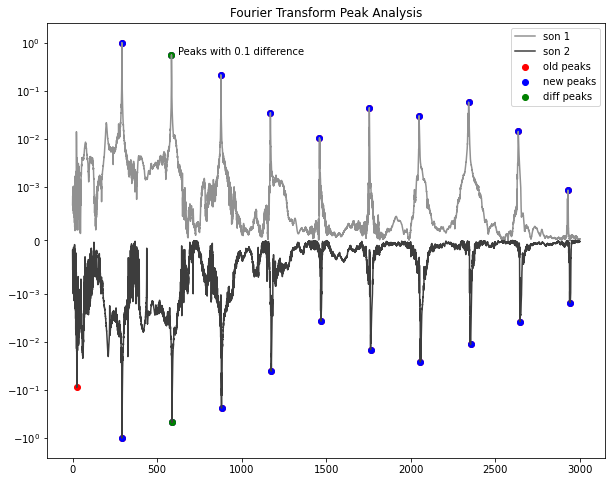

In [61]:
guit.peak_compare(wood, carbon)